$$
\begin{table}[]
\begin{tabular}{llllllllllll}
 &  &  & 0.228 & 0.320 & 0.419 & 0.553 &  &  &  &  &  \\
 &  &  & 0.357 & 2.013 & 2.305 & 0.575 &  &  &  &  &  \\
 &  &  & 0.469 & 0.341 & 0.484 & 2.269 &  &  &  &  &  \\
 &  &  & 0.546 & 0.348 & 0.403 &       &  &  &  &  &  \\
 &  &  & 0.572 & 0.737 &       &       &  &  &  &  &  \\
 &  &  & 0.630 & 0.742 & 0.496 &       &  &  &  &  &  \\
 &  &  &       & 0.601 &       &       &  &  &  &  &  \\
 &  &  &       & 0.558 & 0.408 &       &  &  &  &  & 
\end{tabular}
\end{table}
$$

In [1]:
# Numpy imports:
import numpy as np

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

# for extracting filenames
import glob

# skimage submodules we need
import skimage.io
import skimage.measure
import skimage.filters
import skimage.exposure
import skimage.morphology
from skimage.registration import phase_cross_correlation

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import regionprops
import cv2

#Matplotlib imports
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# # Seaborn imports (stylistic for nice plots)
# import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
#     'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
# sns.set(style='ticks', rc=rc)

#for DataFrames
import pandas as pd

#To interact with the operating system
import os

#For status bar 
from tqdm.notebook import tqdm as tqdm

In [33]:
path = '../../data/atp_hydro/MalachiteGreen/20230202_MalGreen/'
MalGreen_quench30 = pd.read_csv(path+'20230131_MalGreen_quench-30min.txt', header = None) # 30 min after quench samples had Malachite green added
MalGreen_standexp30 = pd.read_csv(path+'20230131_MalGreen_stand-Exp-30min.txt', header = None) # 30 min after standards and regular samples had Malachite green added

In [36]:
MalGreen_quench30

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.182,0.046,2.396,0.228,0.320,0.459,0.553,0.060,0.033,0.047,0.052,0.048
1,0.266,0.046,3.054,0.357,2.013,2.663,0.575,0.069,0.036,0.046,0.055,0.051
2,0.358,0.047,2.698,0.469,0.341,0.512,2.269,0.103,0.037,0.046,0.046,0.047
3,0.431,0.047,2.587,0.546,0.348,0.421,0.057,0.065,0.036,0.046,0.035,0.060
4,0.458,0.049,2.634,0.572,0.737,0.047,0.046,0.047,0.039,0.047,0.038,0.055
5,0.467,0.047,2.692,0.630,0.742,0.523,0.053,0.039,0.037,0.048,0.048,0.047
6,0.048,0.048,2.010,0.046,0.601,0.049,0.041,0.037,0.038,0.046,0.043,0.047
7,0.047,0.049,2.114,0.046,0.558,0.424,0.040,0.070,0.047,0.045,0.047,0.048


In [37]:
MalGreen_standexp30

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.182,0.046,2.328,0.228,0.323,0.460,0.563,0.057,0.042,0.047,0.052,0.048
1,0.266,0.046,3.050,0.356,2.036,2.691,0.577,0.068,0.037,0.046,0.055,0.051
2,0.357,0.047,2.682,0.468,0.337,0.509,2.328,0.105,0.037,0.046,0.046,0.046
3,0.432,0.046,2.580,0.543,0.343,0.433,0.057,0.064,0.036,0.046,0.035,0.060
4,0.456,0.049,2.640,0.567,0.725,0.047,0.046,0.047,0.034,0.047,0.038,0.055
5,0.466,0.047,2.675,0.628,0.753,0.511,0.053,0.039,0.037,0.048,0.048,0.047
6,0.048,0.048,2.005,0.046,0.609,0.049,0.041,0.037,0.038,0.046,0.043,0.047
7,0.047,0.049,2.105,0.046,0.545,0.433,0.040,0.068,0.047,0.045,0.048,0.048


In [58]:
MalGreen = np.zeros(np.shape(MalGreen_quench30))
for i, val in enumerate(MalGreen_standexp30[3][:6]):
    MalGreen[i][3] += val
for i, val in enumerate(MalGreen_standexp30[4]):
    MalGreen[i][4] += val
for i, val in enumerate(MalGreen_quench30[5]):
    MalGreen[i][5] += val
MalGreen[0][6]+= MalGreen_standexp30[6][0]
MalGreen[1][6]+= MalGreen_quench30[6][1]
MalGreen[2][6]+= MalGreen_standexp30[6][2]

MalGreen = pd.DataFrame(MalGreen)
MalGreen

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.228,0.323,0.459,0.563,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.356,2.036,2.663,0.575,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.468,0.337,0.512,2.328,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.543,0.343,0.421,0.000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.567,0.725,0.047,0.000,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.628,0.753,0.523,0.000,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.000,0.609,0.049,0.000,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.000,0.545,0.424,0.000,0.0,0.0,0.0,0.0,0.0


In [85]:
stand_conc = np.array([0, 12.5, 25, 31.25, 37.5, 50]) #µM
stand_abso = np.array(MalGreen[3][:6]) - MalGreen[3][0]

assay = MalGreen[4][0]
EM = MalGreen[4][1] - assay
TaxMT = MalGreen[4][2] - assay
UMT = MalGreen[4][3] - assay
iLidTaxMT = MalGreen[4][4] - assay
iLidUMT = MalGreen[4][5] - assay
microTaxMT = MalGreen[4][6] - assay
microUMT = MalGreen[4][7] - assay

assay_Q = MalGreen[5][0]
EM_Q = MalGreen[5][1]
TaxMT_Q = MalGreen[5][2]
UMT_Q = MalGreen[5][3]
iLidUMT_Q = MalGreen[5][5]
microUMT_Q = MalGreen[5][7]

assayMgATP = MalGreen[6][0] - assay
assayMgATP_Q = MalGreen[6][1] 
EMMgATP = MalGreen[6][2] - assay

In [82]:
def f(pconc, m):
    return m*pconc
def fitstandards(pconc, abso, p0):
    param, cov = curve_fit(f, pconc, abso, p0)
    return param[0]
def abso_to_phos(abso, m):
    return round(abso/m, 1)

m = 0.0089


Text(0, 0.5, 'Absorbance at 620 nm')

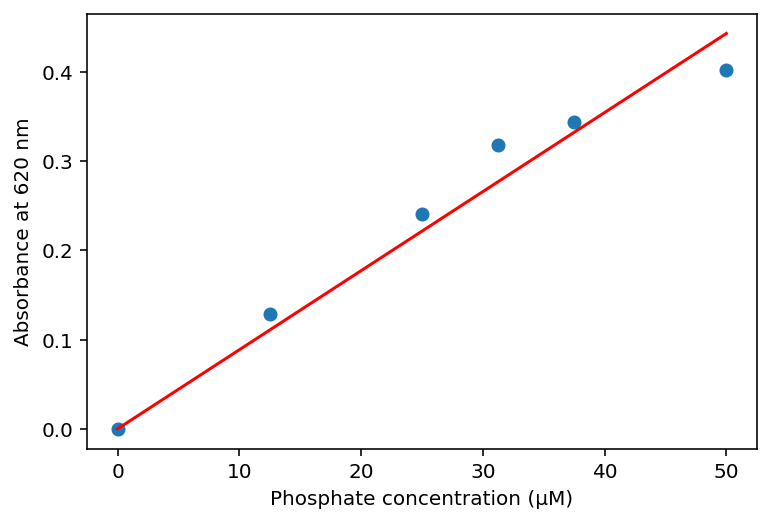

In [80]:
m = fitstandards(stand_conc, stand_abso, [1])
print('m = ' + str(round(m,4)))

plt.plot(stand_conc, m*stand_conc, 'r-', label = 'Fit to Average')
plt.scatter(stand_conc, stand_abs)
plt.xlabel('Phosphate concentration (µM)')
plt.ylabel('Absorbance at 620 nm')


In [87]:
EM_pconc = abso_to_phos(EM, m)
TaxMT_pconc = abso_to_phos(TaxMT, m)
UMT_pconc = abso_to_phos(UMT, m)
iLidTaxMT_pconc = abso_to_phos(iLidTaxMT, m)
iLidUMT_pconc = abso_to_phos(iLidUMT, m)
microTaxMT_pconc = abso_to_phos(microTaxMT, m)
microUMT_pconc = abso_to_phos(microUMT, m)
assayMgATP_pconc = abso_to_phos(assayMgATP, m)
EMMgATP_pconc = abso_to_phos(EMMgATP, m)

In [88]:
print('EM: ' + str(EM_pconc))
print('TaxMT: ' + str(TaxMT_pconc))
print('UMT: ' + str(UMT_pconc))
print('iLid Taxol MT: ' +str(iLidTaxMT_pconc))
print('iLid UMT: ' + str(iLidUMT_pconc))
print('micro Taxol MT: ' +str(microTaxMT_pconc))
print('micro UMT: ' +str(microUMT_pconc))
print('assay with MgATP: ' +str(assayMgATP_pconc))
print('EM MgATP: ' +str(EMMgATP_pconc))

EM: 193.4
TaxMT: 1.6
UMT: 2.3
iLid Taxol MT: 45.4
iLid UMT: 48.6
micro Taxol MT: 32.3
micro UMT: 25.1
assay with MgATP: 27.1
EM MgATP: 226.4


In [101]:
print('[P] in EM: ' +str(round(EM_pconc*40/10, 1)) + ' µM')
print('[P] from EM in aster assay: ' +str(round(EM_pconc*40*4/10/7, 1)) + ' µM')

print('[P] in Taxol MT: ' +str(round(TaxMT_pconc*40/10,1)) + ' µM')
print('[P] in UMT: ' +str(round(UMT_pconc*40/10,1)) + ' µM')
print('[P] from UMT in aster assay: ' +str(round(UMT_pconc*40/10/7, 1)) + ' µM')

print('[P] in 50 mM MgATP aliquot: ' +str(round(assayMgATP_pconc*40*50/10/4,1)) + ' µM')
print('[P] from 1410µM MgATP in aster assay: ' +str(round((assayMgATP_pconc*40*50/10/4)*1.7*4/34.4/7,1)) + ' µM')

[P] in EM: 773.6 µM
[P] from EM in aster assay: 442.1 µM
[P] in Taxol MT: 6.4 µM
[P] in UMT: 9.2 µM
[P] from UMT in aster assay: 1.3 µM
[P] in 50 µM MgATP aliquot: 1355.0 µM
[P] from 1401µM MgATP in aster assay: 38.3 µM


In [111]:
def hydrorate(sample, motconc, rxntime, Rv, Sv):
    return round(sample*Rv/Sv/motconc/rxntime,2)

In [114]:
iLid_conc = 25 #µM
micro_conc = 34 #µM
rxntime = 30*60 #s
Rv = 40 #µl - total reaction volume
Sv = 0.5 #ul - added 1µl of a 1:1 motor dilution

print('[ATP] hydrolyzed by iLid with Taxol MT: ' +str(hydrorate(iLidTaxMT_pconc, iLid_conc, rxntime, Rv, Sv)) + ' ATP/mot*s')
print('[ATP] hydrolyzed by iLid with our GMP-cpp UMT: ' +str(hydrorate(iLidUMT_pconc, iLid_conc, rxntime, Rv, Sv)) + ' ATP/mot*s')
print('[ATP] hydrolyzed by micro with Taxol MT: ' +str(hydrorate(microTaxMT_pconc, micro_conc, rxntime, Rv, Sv)) + ' ATP/mot*s')
print('[ATP] hydrolyzed by micro with our GMP-cpp MT: ' +str(hydrorate(microUMT_pconc, micro_conc, rxntime, Rv, Sv)) + ' ATP/mot*s')

[ATP] hydrolyzed by iLid with Taxol MT: 0.08 ATP/mot*s
[ATP] hydrolyzed by iLid with our GMP-cpp UMT: 0.09 ATP/mot*s
[ATP] hydrolyzed by micro with Taxol MT: 0.04 ATP/mot*s
[ATP] hydrolyzed by micro with our GMP-cpp MT: 0.03 ATP/mot*s


In [109]:
(45.4*40)/(0.5*30*60*25)

0.08071111111111111

In [ ]:
def ATeam_Hill_curve_fit(conc, calavg, maxconc, p0):
    """
    Performs a curve fitting using scipy.optimize.curve_fit to fit data to a Langmuir curve
    
    Parameters
    conc = 1D array of concentrations
    calavg = 1D array of average intensity values of data
    maxconc = scalar Maximum concentration of data taken
    p0 = 1D list with 4 entries of parameter guesses for a, b, c, and d in the Hill function
    
    Returns
    param = 1D list with fit values of each parameter
    curve = 1D array of intensity values for every concentration in xvals
    xvals = 1D array from 0 to maxconc with step size 1
    """
    
    
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(ATeam_Hill, 
                                 conc, 
                                 calavg, 
                                 p0, 
                                 bounds = (np.zeros(4), np.ones([4])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxconc,maxconc)
    curve = ATeam_Hill(xvals, param[0], param[1], param[2], param[3])
    
    return param, curve, xvals

m = 0.0083, b = 0.023


Text(0, 0.5, 'Absorbance at 620 nm')

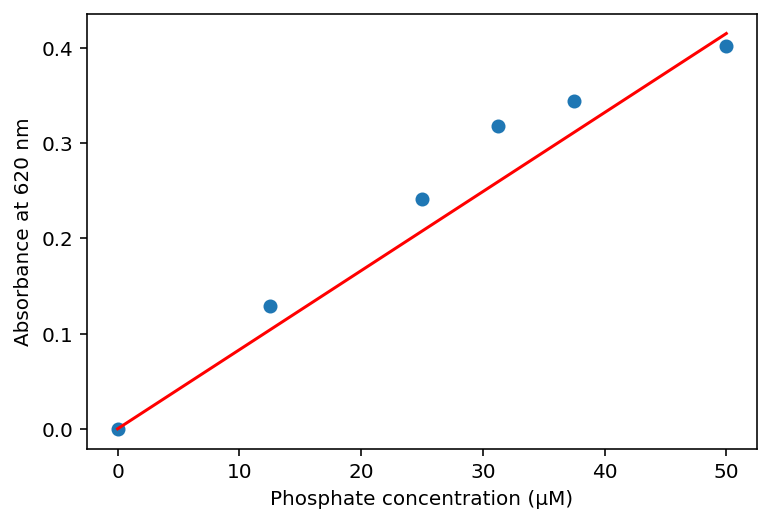

In [66]:
m, b = np.polyfit(stand_conc, stand_abs, 1)
print('m = ' + str(round(m,4)) + ', b = ' + str(round(b,4)))
plt.plot(stand_conc, m*stand_conc, 'r-', label = 'Fit to Average')
plt.scatter(stand_conc, stand_abs)
plt.xlabel('Phosphate concentration (µM)')
plt.ylabel('Absorbance at 620 nm')

In [7]:
def abso_to_phos(abso, m, b):
    return round((abso - b)/m, 1)

Background absorbance detection

In [9]:
bg_abso = 0.320

Amount of phosphate in energy mix, subtract the assay only value from the em only value:

In [10]:
EM_abso = 2.013 - bg_abso
EM_pconc = abso_to_phos(EM_abso, m, b)
EM_pconc

173.8

WOW!! What concentration does this translate to in our aster assay?

In [11]:
EM_pconc*4*4/7

397.25714285714287

$$\frac{(173.8µM)(40µl)}{10µl}\cdot \frac{4}{7} = 397µM$$  YOWZA... that about as much ATP as we normally start with....

How much phosphate do the taxol stabilized ELIPA microtubules contain?

In [13]:
taxMT_abso = 0.341 - bg_abso
taxMT_pconc = abso_to_phos(taxMT_abso, m, b)
taxMT_pconc

-27.7

Ok so negligable... what about our GMPCPP

In [18]:
GMPMT_abso = 0.348 - bg_abso
GMPMT_pconc = abso_to_phos(GMPMT_abso, m, b)
GMPMT_pconc

-26.9

Also negligable?

Now, lets compare how much phosphate we get from using MgATP

In [20]:
MgATP_abso =  0.553 - bg_abso
MgATP_pconc = abso_to_phos(MgATP_abso, m, b)
MgATP_pconc

-2.2

In [22]:
MgATP_abso

0.23300000000000004